# Porosity autodetection for greyscale data

Following Q. Wang et. al., _Experimental study on the performance of a vanadium redox flow battery
with non-uniformly compressed carbon felt electrode_, we will try to redetermine the porosity and intrussion percentage for different channels.

Wang et. al. define porosity as

$a = b+c$

In [1]:
# Libraries for numerical analysis, ploting and reading images
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import cv2
import os
from sklearn.cluster import k_means

In [2]:
# We read images to a dictionary as grayscale
# All files stores as png in the input folder
images = {}
for file in os.listdir("input/"):
    name = file.split(".")[0]
    extension = file.split(".")[1]
    if extension == "png":
        images[name]=cv2.imread("input/"+file, cv2.IMREAD_GRAYSCALE )

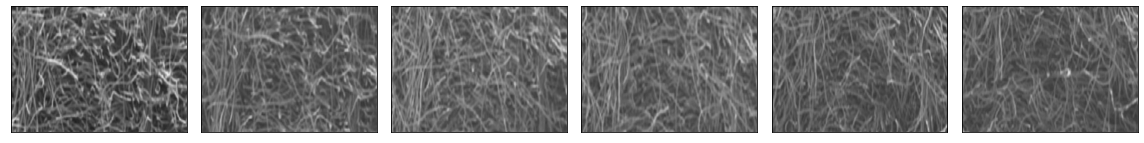

In [3]:
# We plot the images of the array in a columns x rows array. 
# The user has to define the number of columns

columns = 6
rows = len(images.keys())//columns+1
idx = 0
plt.figure(figsize=(16,4))

for name in np.sort([*images]):
    idx +=1
    plt.subplot(rows, columns, idx)
    plt.imshow(images[name], cmap='gray', vmin=0, vmax=255, aspect="auto")
    plt.xticks([])
    plt.yticks([])
    f"CR = {float(name.split('_')[2])/10}%"
plt.tight_layout()
plt.show()

In [4]:
def get_porosity(image, thresh=127, value = 255, kind=cv2.THRESH_BINARY):
    """This functions gets the porosity as defined as 
    
        1 - occupied pixels [%] = free pixels [%]
        
        and returns them for a greyscale image"""
    t, binary = cv2.threshold(image, thresh, value, kind)
    occupied = (binary==value).sum()
    free = (binary!=value).sum()
    return free / (free+occupied)

In [5]:
# We get the porosity for a certain threshold value and it's compression ratio
thresh = 80

CR = np.array([])
p = np.array([])
for name in images.keys():
    CR = np.append(CR, int(name.split("_")[2])/1000)
    p = np.append(p, get_porosity(images[name], thresh))
    
CRind = CR.argsort()
p = p[CRind]
CR = CR[CRind]

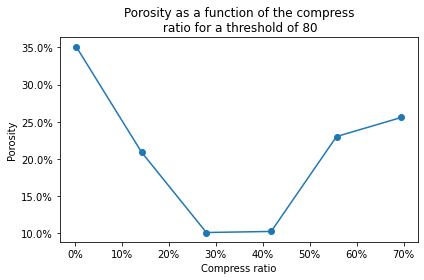

In [6]:
# We plot the porosity
plt.plot(CR, p,'o-')
plt.xlabel("Compress ratio")
plt.ylabel("Porosity")

# We change the axis to be a percent
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

# Title

plt.title(f"Porosity as a function of the compress\n ratio for a threshold of {thresh}")
plt.tight_layout()
plt.show()

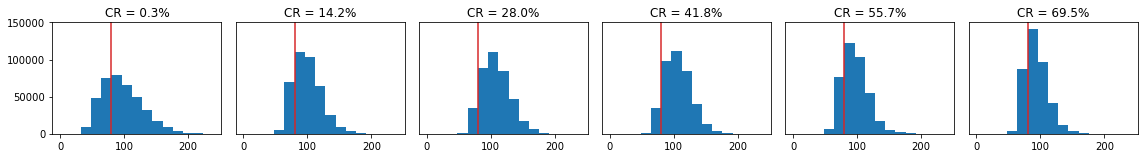

In [7]:
# We plot the images of the array in a columns x rows array. 
# The user has to define the number of columns

columns = 6
rows = len(images.keys())//columns+1
idx = 0
plt.figure(figsize=(16,4))
bins = np.arange(0,256,16)
for name in np.sort([*images]):
    idx +=1
    plt.subplot(rows, columns, idx)
    plt.hist(images[name].flatten(), bins=bins)
    plt.title(f"CR = {float(name.split('_')[2])/10}%")
    plt.ylim(0,150000)
    if idx > 1:
        plt.yticks([])
    plt.plot([thresh, thresh],[0,150000],"C3")
plt.tight_layout()
plt.show()

In [8]:
# We get the porosity for different compress ratios
thresh_val = np.arange(64,129,16)

p_CR = {}
for thresh in thresh_val:
    CR = np.array([])
    p = np.array([])
    for name in images.keys():
        CR = np.append(CR, int(name.split("_")[2])/10)
        p = np.append(p, get_porosity(images[name], thresh))

    CRind = CR.argsort()
    p = p[CRind]
    CR = CR[CRind]
    p_CR[thresh] = p
    
# We get the porosity for OTSU method
CR = np.array([])
p = np.array([])
for name in images.keys():
    CR = np.append(CR, int(name.split("_")[2])/10)
    p = np.append(p, get_porosity(images[name], thresh, kind=cv2.THRESH_OTSU))

CRind = CR.argsort()
p = p[CRind]
CR = CR[CRind]
p_CR["Otsu"] = p

# We get the porosity for kmeans method
CR = np.array([])
p = np.array([])
for name in images.keys():
    CR = np.append(CR, int(name.split("_")[2])/10)
    im = images[name].flatten() 
    im.shape = (len(im),1)
    KM = k_means(im, 2)
    if KM[0][0]>KM[0][1]:
        tmp = KM[1]
        tmp[tmp==0] = 255
        tmp[tmp==1] = 0
    else:
        tmp = KM[1]
        tmp[tmp==1] = 255
        tmp[tmp==0] = 0
    tmp.shape = images[name].shape
    KM = tmp
    p = np.append(p, (KM==0).sum()/((KM==0).sum()+(KM==255).sum()))

CRind = CR.argsort()
p = p[CRind]
CR = CR[CRind]
p_CR["k-means"] = p



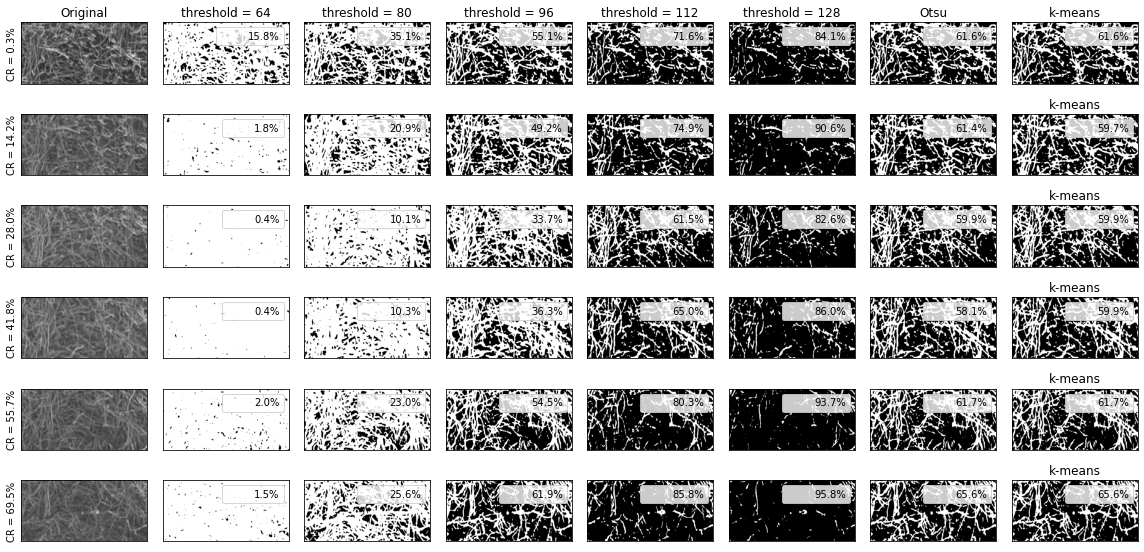

In [9]:
# We plot the images of the array in a columns x rows array. 
# The user has to define the number of columns

columns = len(thresh_val) + 3
rows = len(images.keys())+1
idx = 0
plt.figure(figsize=(16,9))


for name in np.sort([*images]):
    idx +=1
    plt.subplot(rows, columns, idx)
    plt.imshow(images[name], cmap='gray', vmin=0, vmax=255, aspect="auto")
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(f"CR = {float(name.split('_')[2])/10}%")
    if idx == 1:
        plt.title("Original")
    for thresh in thresh_val:
        idx +=1
        plt.subplot(rows, columns, idx)
        plt.imshow(cv2.threshold(images[name], thresh, 255, cv2.THRESH_BINARY)[1], 
                   cmap='gray', vmin=0, vmax=255, aspect="auto")
        plt.xticks([])
        plt.yticks([])
        if idx <= columns:
            plt.title(f"threshold = {thresh}")
        plt.plot([],[],".",label=f"{get_porosity(images[name], thresh)*100:0.1f}%", alpha=0)
        plt.legend()
        
    idx +=1
    
    plt.subplot(rows, columns, idx)
    plt.imshow(cv2.threshold(images[name], 127, 255,cv2.THRESH_OTSU)[1], 
               cmap='gray', vmin=0, vmax=255, aspect="auto")
    plt.xticks([])
    plt.yticks([])
    if idx <= columns:
        plt.title(f"Otsu")
    plt.plot([],[],".",label=f"{get_porosity(images[name], kind=cv2.THRESH_OTSU)*100:0.1f}%", alpha=0)
    plt.legend()

    idx +=1
    im = images[name].flatten() 
    im.shape = (len(im),1)
    KM = k_means(im, 2)
    if KM[0][0]>KM[0][1]:
        tmp = KM[1]
        tmp[tmp==0] = 255
        tmp[tmp==1] = 0
    else:
        tmp = KM[1]
        tmp[tmp==1] = 255
        tmp[tmp==0] = 0
    tmp.shape = images[name].shape
    KM = tmp
    

    plt.subplot(rows, columns, idx)
    plt.imshow(KM,  cmap='gray', vmin=0, vmax=255, aspect="auto")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"k-means")
    plt.plot([],[],".",label=f"{(KM==0).sum()/((KM==0).sum()+(KM==255).sum())*100:0.1f}%", alpha=0)
    plt.legend()
    
plt.tight_layout()
plt.show()

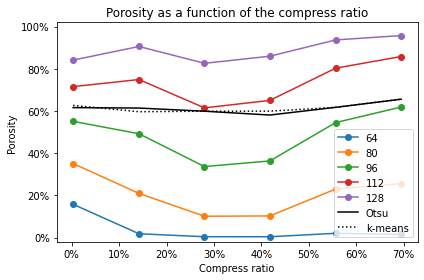

In [10]:
# We plot the porosity
for thresh in p_CR.keys():
    if thresh == "Otsu":
        plt.plot(CR, p_CR[thresh],'-k',label=f"{thresh}")
    elif thresh == "k-means":
        plt.plot(CR, p_CR[thresh],':k',label=f"{thresh}")
    else:
        plt.plot(CR, p_CR[thresh],'o-',label=f"{thresh}")
    

plt.xlabel("Compress ratio")
plt.ylabel("Porosity")
plt.ylim(-0.02,1.02)
plt.legend()

# We change the axis to be a percent
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

# Title

plt.title(f"Porosity as a function of the compress ratio")
plt.tight_layout()
plt.show()

In [25]:
im = images[name]
a = im[:im.shape[0]//2,:im.shape[1]//2]
b = im[im.shape[0]//2:,:im.shape[1]//2]
c = im[:im.shape[0]//2,im.shape[1]//2:]
d = im[im.shape[0]//2:,im.shape[1]//2:]

In [33]:
t = np.arange(0,255,1)
pa = []
pb = []
pc = []
pd = []
for thresh in t:
    pa.append(get_porosity(a, thresh=thresh, value = 255, kind=cv2.THRESH_BINARY))
    pb.append(get_porosity(b, thresh=thresh, value = 255, kind=cv2.THRESH_BINARY))
    pc.append(get_porosity(c, thresh=thresh, value = 255, kind=cv2.THRESH_BINARY))
    pd.append(get_porosity(d, thresh=thresh, value = 255, kind=cv2.THRESH_BINARY))

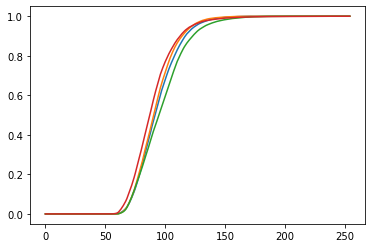

In [37]:
plt.plot(t,pa)
plt.plot(t,pb)
plt.plot(t,pc)
plt.plot(t,pd)